In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
# Parameters
dataset = "CIFAR10"
v_type = "mingd"
root_path = "/data/weijing/ting-dataset-inference/_feature"
params_path = "/data/weijing/ting-dataset-inference/src"
split_index = 512//2


In [3]:
from IPython.display import display, Markdown
v_type2disp = dict(mingd="MinGD", rand="Blind Walk")
display(Markdown(f"# {dataset} - {v_type2disp[v_type]} results"))

# CIFAR10 - MinGD results

In [4]:
import time
import random
from pathlib import Path
from tqdm.auto import tqdm
from importlib import reload
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np
import os
import sys
sys.path.insert(0, params_path)


torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


In [5]:
import seaborn as sns
import pandas as pd
import os

In [6]:
from scipy.stats import combine_pvalues, ttest_ind_from_stats, ttest_ind
from functools import reduce
from scipy.stats import hmean

## Use the full vectors to train a linear model

In [7]:
root = os.path.join(root_path, dataset)
model_types = [
    'zero-shot',
    'prune',
    'fine-tune',
    'extract-label',
    'extract-logit',
    'distillation',
    'teacher',
]

names = [
    "CIFAR-CINIC-100-0",
    "CIFAR-CINIC-90-10",
    "CIFAR-CINIC-80-20",
    "CIFAR-CINIC-60-40",
    "CIFAR-CINIC-40-60",
    "CIFAR-CINIC-20-80",
    "CIFAR-CINIC-10-90",
    "CIFAR-CINIC-0-100",
]
victim_name = "CIFAR-CINIC-100-0"


In [8]:
# if v_type == "mingd" and dataset == "CIFAR100": v_type = "topgd"

trains = {}
tests = {}
for name in names:
    trains[name] = (torch.load(f"{root}/model_wrn-28-10_normalized-{name}/train_{v_type}_vulnerability_500.pt"))
    tests[name] = (torch.load(f"{root}/model_wrn-28-10_normalized-{name}/test_{v_type}_vulnerability_500.pt"))
mean_cifar = trains[victim_name].mean(dim = (0,1))
std_cifar = trains[victim_name].std(dim = (0,1))

In [9]:
if v_type == "mingd":
    for name in names:
        trains[name] = trains[name].sort(dim=1)[0]
        tests[name] = tests[name].sort(dim=1)[0]

for name in names:
    trains[name] = (trains[name] - mean_cifar)/std_cifar
    tests[name] = (tests[name] - mean_cifar)/std_cifar

f_num = 30
a_num = 30
num_row = 512 # added, because newly trained model is 1024, original is 1000

trains_n = {}
tests_n = {}
for name in names:
    trains_n[name] = trains[name].T.reshape(num_row, f_num)[:, :a_num]
    tests_n[name] = tests[name].T.reshape(num_row, f_num)[:, :a_num]


In [10]:
n_ex = split_index
train = torch.cat((trains_n[victim_name][:n_ex], tests_n[victim_name][:n_ex]), dim = 0)
y = torch.cat((torch.zeros(n_ex), torch.ones(n_ex)), dim = 0)

rand=torch.randperm(y.shape[0])
train = train[rand]
y = y[rand]

In [11]:
print(train[15])

tensor([ 0.5831, -0.5136,  0.0579,  0.1442,  0.3123, -0.4403, -0.8747, -0.6600,
         0.3097, -0.7035,  2.2334, -1.1035,  0.0534,  1.3135,  1.2338,  0.2336,
        -0.3806,  1.5475,  0.2667,  0.1854,  0.5775, -0.9075, -1.2531,  0.3465,
         0.8221, -0.2088,  0.3350,  1.6975, -0.2629,  0.1924])


In [12]:
model = nn.Sequential(nn.Linear(a_num,100),nn.ReLU(),nn.Linear(100,1),nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer =torch.optim.SGD(model.parameters(), lr=0.1)

In [13]:
with tqdm(range(1000)) as pbar:
    for epoch in pbar:
        optimizer.zero_grad()
        inputs = train
        outputs = model(inputs)
        loss = -1 * ((2*y-1)*(outputs.squeeze(-1))).mean()
        loss.backward()
        optimizer.step()
        pbar.set_description('loss {}'.format(loss.item()))

  0%|          | 0/1000 [00:00<?, ?it/s]

## Dataset Inference

In [14]:
def get_p(outputs_train, outputs_test):
    pred_test = outputs_test[:,0].detach().cpu().numpy()
    pred_train = outputs_train[:,0].detach().cpu().numpy()
    tval, pval = ttest_ind(pred_test, pred_train, alternative="greater", equal_var=False)
    if pval < 0:
        raise Exception(f"p-value={pval}")
    return pval

def get_p_values(num_ex, train, test, k):
    total = train.shape[0]
    sum_p = 0
    p_values = []
    positions_list = []
    for i in range(k):
        positions = torch.randperm(total)[:num_ex]
        p_val = get_p(train[positions], test[positions])
        positions_list.append(positions)
        p_values.append(p_val)
    return p_values

def get_fischer(num_ex, train, test, k):
    p_values = get_p_values(num_ex, train, test, k)
    return combine_pvalues(p_values, method="mudholkar_george")[1]

def get_max_p_value(num_ex, train, test, k):
    p_values = get_p_values(num_ex, train, test, k)
    return max(p_values)

In [15]:
outputs_tr = {}
outputs_te = {}
for name in names:
    outputs_tr[name] = model(trains_n[name])
    outputs_te[name] = model(tests_n[name])

In [16]:
import scipy.stats as stats
def print_inference(outputs_train, outputs_test):
    m1, m2 = outputs_test[:,0].mean(), outputs_train[:,0].mean()
    pval = get_p(outputs_train, outputs_test)
    print(f"p-value = {pval} \t| Mean difference = {m1-m2}")

In [17]:
for name in names:
    outputs_tr[name], outputs_te[name] = outputs_tr[name][split_index:], outputs_te[name][split_index:]

In [18]:
for name in names:
    print(f"{name}")
    print_inference(outputs_tr[name], outputs_te[name])

CIFAR-CINIC-100-0
p-value = 1.1869338660868378e-07 	| Mean difference = 0.33284085988998413
CIFAR-CINIC-90-10
p-value = 1.2579830863171972e-07 	| Mean difference = 0.33218786120414734
CIFAR-CINIC-80-20
p-value = 1.284344862438442e-07 	| Mean difference = 0.3312264084815979
CIFAR-CINIC-60-40
p-value = 1.4306369730353124e-07 	| Mean difference = 0.32911333441734314
CIFAR-CINIC-40-60
p-value = 1.42489033494651e-07 	| Mean difference = 0.329074501991272
CIFAR-CINIC-20-80
p-value = 1.5781507199321e-07 	| Mean difference = 0.3269542157649994
CIFAR-CINIC-10-90
p-value = 1.580822247094695e-07 	| Mean difference = 0.32596248388290405
CIFAR-CINIC-0-100
p-value = 1.6796501603295187e-07 	| Mean difference = 0.3237791955471039


## Main Loop

In [19]:
# result path
RESULT_DIR_PATH = Path.cwd() / "_result"
RESULT_FILE_PATH = RESULT_DIR_PATH / f"{dataset}_CIFAR-CINIC_wrn-28-10_normalized_{v_type}.h5"

RESULT_DIR_PATH.mkdir(parents=True, exist_ok=True)

In [20]:
if not RESULT_FILE_PATH.exists():
    total_reps = 40
    max_m = 200
    total_inner_rep = 100

    m_list = [x for x in range(2, max_m, 1)]
    p_values_all_threat_models_dict = {}

    n_pbar = tqdm(names, leave=False)
    for name in n_pbar:
        p_vals_per_rep_no = {}
        r_pbar = tqdm(range(total_reps), leave=False)
        for rep_no in r_pbar:
            p_values_list = []
            for m in m_list:
                p_list = get_p_values(m, outputs_tr[name], outputs_te[name], total_inner_rep)
                try:
                    hm = hmean(p_list)
                except:
                    hm = 1.0
                p_values_list.append(hm)
                pbar.set_description(f"{rep_no: 2d} {name} m={m: 3d}: f{hm: 0.5f}")
            r_pbar.set_description(f"rep_no: {rep_no+1}/{total_reps}")
            p_vals_per_rep_no[rep_no] = p_values_list
        p_values_all_threat_models_dict[name] = p_vals_per_rep_no
        
    df_list = []
    for name, rep_dict in p_values_all_threat_models_dict.items():
        df = pd.DataFrame(rep_dict).reset_index().assign(m=lambda r: r.index+2).drop(["index"], axis=1)
        df_list.append(pd.melt(df,id_vars=["m"], var_name="rep_no", value_name="p_value").assign(threat_model=name))
    results_df = pd.concat(df_list)
    
    results_df.to_hdf(RESULT_FILE_PATH, v_type)
    results_df
else:
    results_df = pd.read_hdf(RESULT_FILE_PATH, v_type)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_27758/521628443.py:33: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['rep_no', 'threat_model'], dtype='object')]

  results_df.to_hdf(RESULT_FILE_PATH, v_type)


#### Plotting

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.latex.preamble'] = r'\usepackage{times}'

plt.rcParams.update({
    "text.usetex": True,
})

#### Renaming

In [22]:
# rename_dict = {
#     "threat_model": "Threat Model",
#     "teacher": "Source",
#     "distillation": "Distillation",
#     "extract-label": "Label-Query",
#     "extract-logit": "Logit-Query",
#     "zero-shot": "Zero-Shot Learning",
#     "fine-tune": "Fine-Tuning",
#     "pre-act-18": "Diff. Architecture",
# }

rename_dict = {
    "threat_model": "Threat Model",
    "CIFAR-CINIC-100-0": "Source / 100-0",
    "CIFAR-CINIC-90-10": "90-10",
    "CIFAR-CINIC-80-20": "80-20",
    "CIFAR-CINIC-60-40": "60-40",
    "CIFAR-CINIC-40-60": "40-60",
    "CIFAR-CINIC-20-80": "20-80",
    "CIFAR-CINIC-10-90": "10-90",
    "CIFAR-CINIC-0-100": "0-100",
}


In [23]:
plot_df = (results_df.rename(columns=rename_dict).replace(rename_dict)
           .query('(m >= 5)')
          )

In [24]:
# Sizes
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 1
BIGGER_SIZE = MEDIUM_SIZE + 1
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsi ze of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [25]:
plot_df[plot_df.index.duplicated()]
plot_df.reset_index(inplace=True)

In [26]:
plot_df

,index,m,rep_no,p_value,Threat Model
0,3,5,0,1.304391e-01,Source / 100-0
1,4,6,0,6.606929e-02,Source / 100-0
2,5,7,0,7.243375e-02,Source / 100-0
3,6,8,0,6.794691e-02,Source / 100-0
4,7,9,0,2.424833e-02,Source / 100-0
...,...,...,...,...,...
62395,7915,195,39,6.326163e-07,0-100
62396,7916,196,39,3.617726e-07,0-100
62397,7917,197,39,1.970940e-07,0-100
62398,7918,198,39,9.583799e-08,0-100


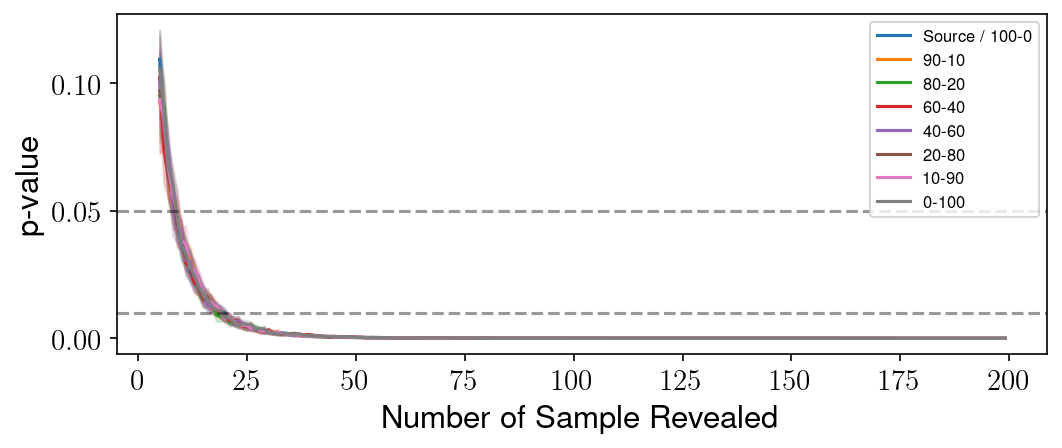

In [29]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=150)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
g.set_xlabel("Number of Sample Revealed")
g.set_ylabel("p-value")
# g.set_xlim([0, 25])
# g.set_ylim([-0.001, 0.005])
plt.legend(fontsize=8, loc="best")

In [28]:
assert False

AssertionError: 

# Table

In [ ]:
from utils import generate_table
tab = generate_table(selected_m=10, outputs_te=outputs_te, outputs_tr=outputs_tr, names=names)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
with pd.option_context("display.float_format", lambda x: f"{x: 0.3f}"):
    print(tab)

               mean_diff  p_value
teacher            1.823    0.000
distillation       0.778    0.000
pre-act-18         1.400    0.000
zero-shot          0.406    0.010
fine-tune          1.839    0.000
extract-label      1.006    0.001
extract-logit      1.048    0.000
independent       -0.397    0.675


In [ ]:
with pd.option_context("display.float_format", lambda x: f"{x: 0.3f}"):
    print(tab.to_latex(formatters=dict(mean_diff="{:0.3f}".format, p_value=lambda x: "$10^{"+f"{x:0.0E}"[2:]+"}$"), escape=False))

\begin{tabular}{lrr}
\toprule
{} & mean_diff &    p_value \\
\midrule
teacher       &     1.823 & $10^{-42}$ \\
distillation  &     0.778 & $10^{-05}$ \\
pre-act-18    &     1.400 & $10^{-10}$ \\
zero-shot     &     0.406 & $10^{-02}$ \\
fine-tune     &     1.839 & $10^{-27}$ \\
extract-label &     1.006 & $10^{-04}$ \\
extract-logit &     1.048 & $10^{-04}$ \\
independent   &    -0.397 & $10^{-01}$ \\
\bottomrule
\end{tabular}

